In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import os
torch.set_printoptions(precision=5)
output_dir = "C:/Users/lix23/Desktop/CPM/"

In [2]:
def parse_args():
  parser = argparse.ArgumentParser()

  parser.add_argument('--z_dim', default=10, type=int) 
  parser.add_argument('--x_dim', default=3, type=int) 
  parser.add_argument('--y_dim', default=3, type=int)
  parser.add_argument('--K_dim', default=3, type=int)
  parser.add_argument('--output_layer', default=[128,128]) 
  parser.add_argument('--num_samples', default=100) 
  parser.add_argument('--langevin_K', default=100)
  parser.add_argument('--langevin_s', default=0.1) 
  parser.add_argument('--kappa', default=0.1)
  parser.add_argument('--penalties', default=[0.1,1,10,50,100,1000], type=int)
  parser.add_argument('--time_embed_dim', default=16, type=int)
  
  parser.add_argument('--epoch', default=50)
  parser.add_argument('--decoder_iteration', default=20)
  parser.add_argument('--nu_iteration', default=20)
  parser.add_argument('--decoder_lr', default=0.01)
  parser.add_argument('--decoder_thr', default=0.001)
  parser.add_argument('--iter_thr', default=5)
  parser.add_argument('--loss_thr', default=0.00001)

  parser.add_argument('--use_data', default='XXX')
  parser.add_argument('--num_seq', default=100)
  parser.add_argument('--num_time', default=200)
  parser.add_argument('--data_dir', default='./data/')
  parser.add_argument('-f', required=False)

  args, _ = parser.parse_known_args()
  return args


args = parse_args()
print(args)
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print('[INFO]', device)



#################
# LOSS FUNCTION #   
#################

# Write a loss function for infer_z() use. This version is idendity matrix case.

# def mixture_of_gaussians_loss(y, pi, mean):
#     """
#     y:    (N, D)
#     pi:   (N, K)
#     mean: (N, K, D)
#     """
#     N, K, D = mean.shape
    
#     # expand y -> (N, K, D)
#     y_expand = y.unsqueeze(1).expand(-1, K, -1)
    
#     # squared Euclidean distance ||y - mu||^2
#     diff_sq = torch.sum((y_expand - mean) ** 2, dim=-1)   # (N, K)
    
#     # Gaussian pdf with identity covariance
#     norm_const = 1.0 / ((2 * torch.pi) ** (D / 2))
#     pdf_vals = norm_const * torch.exp(-0.5 * diff_sq)     # (N, K)
    
#     # mixture: sum_k pi * pdf
#     weighted = pi * pdf_vals
#     total = torch.sum(weighted, dim=1)                    # (N,)
    
#     # negative log-likelihood
#     nll = -torch.sum(torch.log(total + 1e-10))
#     return nll

# Finished 2025-08-20 9:48 AM PST

# Another Version, diagonal case.


def mixture_of_gaussians_loss(y, pi, mean, sigma):
    """
    y:     (N, D)
    pi:    (N, K)
    mean:  (N, K, D)
    sigma: (N, K, D)  
    """
    N, K, D = mean.shape

    # expand y to (N, K, D)
    y_expand = y.unsqueeze(1).expand(-1, K, -1)

    # (y - mu)^2 / sigma
    diff = y_expand - mean
    mahal = torch.sum((diff**2) / (sigma + 1e-8), dim=2)  # (N, K)

    # log det of diagonal cov
    log_det = torch.sum(torch.log(sigma + 1e-8), dim=2)  # (N, K)

    # log Gaussian pdf
    log_prob = -0.5 * (D * np.log(2*np.pi) + log_det + mahal)  # (N, K)

    # mixture likelihood
    weighted = pi * torch.exp(log_prob)  # (N, K)
    total_prob = torch.sum(weighted, dim=1)  # (N,)

    # negative log-likelihood
    nll = -torch.sum(torch.log(total_prob + 1e-12))
    return nll





Namespace(z_dim=10, x_dim=3, y_dim=3, K_dim=3, output_layer=[128, 128], num_samples=100, langevin_K=100, langevin_s=0.1, kappa=0.1, penalties=[0.1, 1, 10, 50, 100, 1000], time_embed_dim=16, epoch=50, decoder_iteration=20, nu_iteration=20, decoder_lr=0.01, decoder_thr=0.001, iter_thr=5, loss_thr=1e-05, use_data='XXX', num_seq=100, num_time=200, data_dir='./data/', f=None)
[INFO] cuda:0


In [3]:
###################
# LOAD SAVED DATA #
###################


import pandas as pd
import numpy as np
import torch


# x_df = pd.read_csv("x_all.csv")
# z_df = pd.read_csv("z_all.csv")
# y_df = pd.read_csv("y_all.csv")
# meta_df = pd.read_csv("data_all.csv")

# x_all = x_df.values   # (20000, 3)
# z_all = z_df.values   # (20000, 3)
# y_all = y_df.values   # (20000, 3)

# # Check dimension match 
# X_rec = x_all.reshape(args.num_time, args.num_samples, args.x_dim)
# # Z_rec = z_all.reshape(args.num_time, args.num_samples, args.z_dim)
# Y_rec = y_all.reshape(args.num_time, args.num_samples, args.y_dim)

# X_torch = torch.tensor(X_rec, dtype=torch.float32)
# # Z_torch = torch.tensor(Z_rec, dtype=torch.float32)
# Y_torch = torch.tensor(Y_rec, dtype=torch.float32)


# Initialize the weights
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param.data, -0.05, 0.05)


In [4]:
#########
# MODEL #
#########

class CPD(nn.Module):
  def __init__(self, args, half):
    super(CPD, self).__init__()

    self.d = args.z_dim
    self.p = args.x_dim
    self.K = args.K_dim           # mixture components
    self.D = args.y_dim           # output dim = 3
    self.T = int(args.num_time/2) if half else args.num_time

    self.l1 = nn.Linear(self.d + self.p, args.output_layer[0])
    self.l2 = nn.Linear(args.output_layer[0], args.output_layer[1])

    self.l3_pi    = nn.Linear(args.output_layer[1], self.K)          # (TB, K)
    self.l3_mean  = nn.Linear(args.output_layer[1], self.K * self.D) # (TB, K*3)
    self.l3_sigma = nn.Linear(args.output_layer[1], self.K * self.D) # (TB, K*3)
    
  def forward(self, x, z):
    output = torch.cat([x, z], dim=1)
    output = self.l1(output).tanh()
    output = self.l2(output).tanh()

    pi = self.l3_pi(output).softmax(dim=1)                  # (TB, K)
    mean = self.l3_mean(output).reshape(-1, self.K, self.D) # (TB, K, D)
    sigma = F.softplus(self.l3_sigma(output)).reshape(-1, self.K, self.D) + 1e-6

    # covs = []
    # for k in range(self.K):
    #     # cov_matrix = torch.diag_embed(sigma[:, k, :]**2)    # (TB, D, D)
    #     cov_matrix = torch.diag_embed(torch.ones(self.D).to(device))
    #     covs.append(cov_matrix)
    # covs = torch.stack(covs, dim=1)  # (TB, K, D, D)

    return pi, mean, sigma

  def infer_z(self, x, z, y, mu_repeat, args):
    """
    x: (T*B, p)
    z: (T*B, d)
    y: (T*B, D)   # target
    mu_repeat: (T*B, d)  # prior mean for z
    """
    for k in range(args.langevin_K):
        z = z.detach().clone().requires_grad_(True)

        # forward
        pi, mean, sigma = self.forward(x, z)

        # compute NLL loss
        nll = mixture_of_gaussians_loss(y, pi, mean, sigma)

        # gradient wrt z
        z_grad_nll = torch.autograd.grad(nll, z)[0]

        # Langevin noise
        noise = torch.randn_like(z).to(z.device)

        # update
        z = z + args.langevin_s * (-z_grad_nll - (z - mu_repeat)) \
              + torch.sqrt(torch.tensor(2.0 * args.langevin_s)) * noise

    return z.detach()





In [5]:
def learn_one_seq_penalty(args,x_input_train, y_input_train, x_input_test, y_input_test, penalty, half):
  m = args.num_samples
  kappa = args.kappa
  d = args.z_dim
  pen_iter = 0
  penalty = penalty
  print('\n[INFO] Penalty', penalty)
  early_stopping = False
  stopping_count = 0 # for ADMM
  
  T = x_input_train.shape[0] // args.num_samples   
  
  # create matrix X and vector 1
  ones_col = torch.ones(T, 1).to(device)
  X = torch.zeros(T, T-1).to(device)
  i, j = torch.tril_indices(T, T-1, offset=-1)
  X[i, j] = 1 # Group Fused Lasso
  
  old_loss_train = -float('inf')
  loss_train_holder = []
  loss_test_holder = []
  mu_diff_holder = []
  decoder_loss_holder = []
  CV_holder = []

  if not half:
    best_mu = torch.zeros(T,d)
    best_loglik = torch.zeros(1)
    best_CV = -float('inf') # Coefficient of Variation
    best_CV_iter = 0
  # initialize mu, nu, w, with dim T by d of zeros
  mu = torch.zeros(T, d).to(device)
  nu = torch.zeros(T, d).to(device)
  w = torch.zeros(T, d).to(device)

  mu_old = mu.detach().clone()
  nu_old = nu.detach().clone()

  # Use y_input directly, no need to repeat

  model = CPD(args, half = False).to(device)
  model.apply(init_weights)
  optimizer = torch.optim.Adam(model.parameters(), lr=args.decoder_lr)
  for learn_iter in range(args.epoch):
    print('\n[INFO] Epoch', learn_iter)
    ####################
    # GENERATE SAMPLES #
    ####################
    # create repeated version of mu, from (T by d) to (Tm by d)
    mu_repeat = mu.repeat_interleave(m, dim=0) # Tm by d
    init_z = torch.randn(T*m, d).to(device) # Tm by d, starts from N(0,1)
    print(mu_repeat.shape)
    print(init_z.shape)
    sampled_z_all = model.infer_z(x_input_train, init_z, y_input_train, mu_repeat, args) # Tm by d

    ################
    # UPDATE PRIOR # 
    ################
    expected_z = sampled_z_all.clone().reshape(T,m,d) # T by m by d
    expected_z = expected_z.mean(dim=1) # T by d
    mu = ( expected_z + kappa * (nu-w) ) / ( 1.0 + kappa )
    mu = mu.detach().clone()

    ##################
    # UPDATE DECODER #
    ##################
    inner_loss = float('inf')
    for decoder_iter in range(args.decoder_iteration):
        optimizer.zero_grad()
        pi, mean, sigma  = model(x_input_train, sampled_z_all) # Tm by n by n 
        loss_train = mixture_of_gaussians_loss(y_input_train, pi, mean, sigma)/m
        loss_train.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

    #########################
    # UPDATE BETA AND GAMMA #
    #########################
  
    gamma = nu[0, :].unsqueeze(0) # row vector
    beta = torch.diff(nu, dim=0)

    for nu_iter in range(args.nu_iteration):
        # update beta once (t range from 1 to 99, NOT 1 to 100)
        for t in range(T-1): 
          beta_without_t = beta.detach().clone()
          X_without_t = X.detach().clone()
          beta_without_t[t,:] = torch.zeros(d) # make this row zeros
          X_without_t[:,t] = torch.zeros(T) # make this column zeros
          bt = kappa * torch.mm( X[:,t].unsqueeze(0), mu + w - torch.mm(ones_col, gamma) - torch.mm(X_without_t, beta_without_t) )
          bt_norm = torch.norm(bt, p=2)

          # UPDATE: soft-thresholding
          if bt_norm < penalty:
              beta[t,:] = torch.zeros(d)
          else:
              beta[t,:] = 1 / (kappa * torch.norm(X[:,t], p=2)**2) * (1 - penalty/bt_norm) * bt
          beta = beta.detach().clone()

        # update gamma
        gamma = torch.mean(mu + w - torch.mm(X, beta), dim=0).unsqueeze(0).detach().clone()

    # recollect nu
    nu = torch.mm(ones_col, gamma) + torch.mm(X, beta)
    nu = nu.detach().clone()

    ############
    # UPDATE W # 
    ############

    w = mu - nu + w
    w = w.detach().clone()

    ############
    # RESIDUAL # 
    ############

    primal_residual = torch.sqrt(torch.mean(torch.square(mu - nu)))
    dual_residual = torch.sqrt(torch.mean(torch.square(nu - nu_old)))

    # if primal_residual > 10.0 * dual_residual:
    #     kappa *= 2.0
    #     w *= 0.5
    #     print('\n[INFO] kappa increased to', kappa)
    # elif dual_residual > 10.0 * primal_residual:
    #     kappa *= 0.5
    #     w *= 2.0
    #     print('\n[INFO] kappa decreased to', kappa)
    
    # with torch.no_grad():      
      # # Early Stopping - llh
      # if half:
      #   loss_train = mixture_of_gaussians_loss(y_input_train, pi, mean, sigma)/m # USE TRAIN
      #   loss_train_holder.append(loss_train.detach().cpu().numpy().item())
      #   mu_repeat = mu.repeat_interleave(m, dim=0) # Tm by d
      #   init_z = torch.randn(T*m, d).to(device) # Tm by d, starts from N(0,1)
      #   sampled_z_all_test = model.infer_z(x_input_test, init_z, y_input_test, mu_repeat, args) # Tm by d
      #   pi_test, mean_test, sigma_test  = model(x_input_test, sampled_z_all_test) # Tm by n by n 
      #   loss_test = mixture_of_gaussians_loss(y_input_test, pi_test, mean_test, sigma_test)/m
      #   loss_test_holder.append(loss_test.detach().cpu().numpy().item())
      # else:
      #   loss_train = mixture_of_gaussians_loss(y_input_train, pi, mean, sigma)/m # USE TRAIN
      #   loss_train_holder.append(loss_train.detach().cpu().numpy().item())
      # Early Stopping - llh
    if half:
        # training loss
        loss_train = mixture_of_gaussians_loss(y_input_train, pi, mean, sigma) / m
        loss_train_holder.append(loss_train.detach().cpu().item())

        # freeze model parameters (no grad for θ)
        for param in model.parameters():
            param.requires_grad = False

        # still allow z to require grad
        mu_repeat = mu.repeat_interleave(m, dim=0)  # (T*m, d)
        init_z = torch.randn(T*m, d, device=device, requires_grad=True)

        # inference step
        sampled_z_all_test = model.infer_z(x_input_test, init_z, y_input_test, mu_repeat, args)
        pi_test, mean_test, sigma_test = model(x_input_test, sampled_z_all_test)

        # test loss
        loss_test = mixture_of_gaussians_loss(y_input_test, pi_test, mean_test, sigma_test) / m
        loss_test_holder.append(loss_test.detach().cpu().item())

        # restore model parameters to be trainable for next epoch
        for param in model.parameters():
            param.requires_grad = True
    else:
        # only training loss
        loss_train = mixture_of_gaussians_loss(y_input_train, pi, mean, sigma) / m
        loss_train_holder.append(loss_train.detach().cpu().item())

    loss_relative_diff = torch.abs((loss_train - old_loss_train) / old_loss_train)
    old_loss_train = loss_train.detach().clone()
    # mu diff criteria
    mu_relative_diff = torch.norm(mu-mu_old, p='fro')
    mu_diff_holder.append(mu_relative_diff.detach().cpu().numpy().item())
    
    mu_old = mu.detach().clone()
    nu_old = nu.detach().clone()
    #####################
    # STOPPING CRITERIA #
    #####################

    if loss_relative_diff < args.loss_thr:
      stopping_count += 1
    else:
      stopping_count = 0

    if stopping_count >= args.iter_thr:
      print('\n[INFO] early stopping')
      early_stopping = True        
      
      
    if (learn_iter+1) % 10 == 0:
      # print(learn_iter)
      with torch.no_grad():
        # second row - first row
        delta_mu = torch.norm(torch.diff(mu, dim=0), p=2, dim=1)
        delta_mu = delta_mu.cpu().detach().numpy() # numpy for plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 8))

      # subplot 1: delta_mu
        axes[0].plot(delta_mu)
        if not half:
          axes[0].axvline(x=args.num_time/2-1, color="red", linestyle="--", linewidth=1)
        axes[0].set_title("Δμ (row diff norm)")

        # # subplot 2: log-likelihood
        # axes[0,1].plot(loglik_train_holder[1:])
        # axes[0,1].set_title("Training log-likelihood")

        # subplot 3: mu difference holder
        axes[1].plot(mu_diff_holder[1:])
        axes[1].set_title("μ diff holder")

        # # subplot 4: CV holder
        # axes[1,1].plot(CV_holder)
        # axes[1,1].set_title("CV holder")

        plt.tight_layout()
        plt.show()

        # print('\nlearning iter (seq={}, [penalty={}], data={}) ='.format(seq_iter,penalty,label), learn_iter+1, 'of', args.epoch)
        print('\ttrain_loss =', loss_train.item())
        print('\tprimal residual =', primal_residual)
        print('\tdual residual =', dual_residual)
        print('\t\tloss relative difference =', loss_relative_diff)
        print('\t\tmu relative difference =', mu_relative_diff)
    ###############
    # SAVE RESULT #
    ###############
    # at the last iteration or early_stopping
    if (learn_iter+1) == args.epoch or early_stopping:

      with torch.no_grad():
        if half: # Use this to do cv
          return loss_test.detach().cpu().numpy(), penalty
        else:
          # USE THE BEST MU
          return loss_train.detach().cpu().numpy(), mu.detach().cpu().numpy()

  
  


In [7]:
x_all = pd.read_csv("./sim_data/x_all_1comp.csv").iloc[:, 2:].values  # (T*N, dx)
z_all = pd.read_csv("./sim_data/z_all_1comp.csv").iloc[:, 2:].values   # (T*N, dz)
y_all = pd.read_csv("./sim_data/y_all_1comp.csv").iloc[:, 2:].values   # (T*N, dy)

x_all = pd.read_csv("./sim_data/x_all.csv").iloc[:, 2:].values   # (T*N, dx)
z_all = pd.read_csv("./sim_data/z_all.csv").iloc[:, 2:].values   # (T*N, dz)
y_all = pd.read_csv("./sim_data/y_all.csv").iloc[:, 2:].values   # (T*N, dy)

x_all = pd.read_csv("./sim_data/x_all_3cp.csv").iloc[:, 2:].values   # (T*N, dx)
z_all = pd.read_csv("./sim_data/z_all_3cp.csv").iloc[:, 2:].values   # (T*N, dz)
y_all = pd.read_csv("./sim_data/y_all_3cp.csv").iloc[:, 2:].values   # (T*N, dy)

x_input = torch.tensor(x_all, dtype=torch.float32).to(device)
z_input = torch.tensor(z_all, dtype=torch.float32).to(device)
y_input = torch.tensor(y_all, dtype=torch.float32).to(device)

In [8]:
# Important : k = 1, dz = 5. kappa = 0.5, penalty = 10000, epoch = 30  is good
# Important : k = 3, dz = 10, epoch = 50, decoder_lr = 0.01, penalty = 10000, is good
args.epoch = 30
args.z_dim = 1




[INFO] Penalty 0.1

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


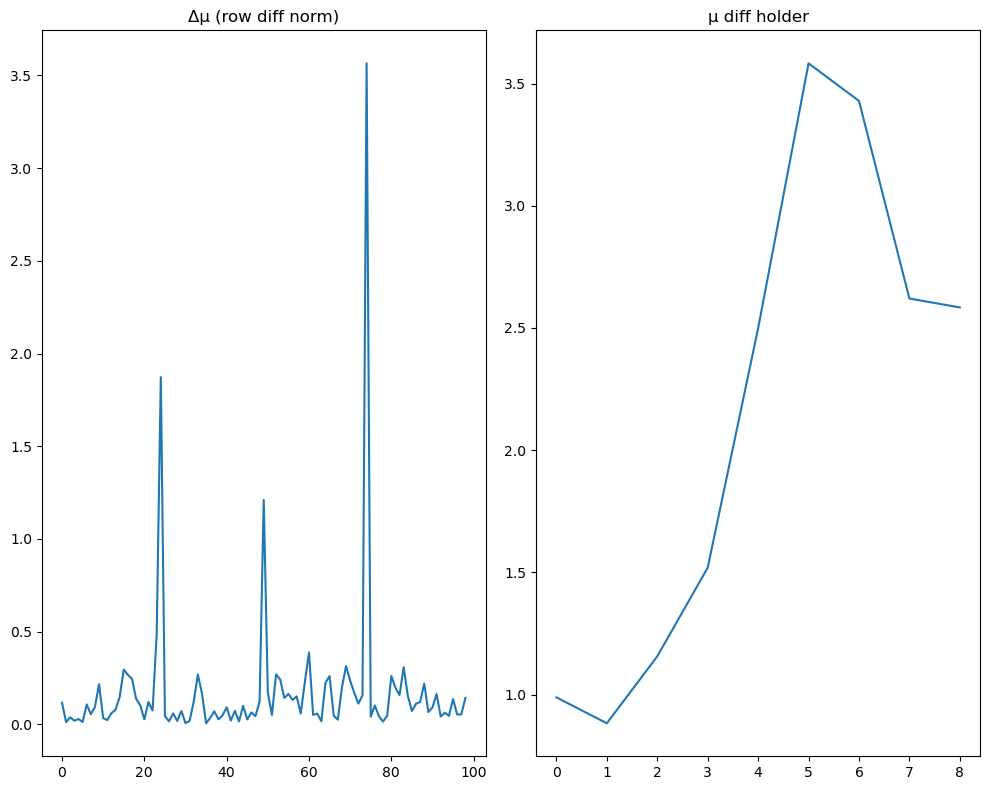

	train_loss = 639.4853515625
	primal residual = tensor(0.08845, device='cuda:0')
	dual residual = tensor(0.23537, device='cuda:0')
		loss relative difference = tensor(0.05726, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(2.58397, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


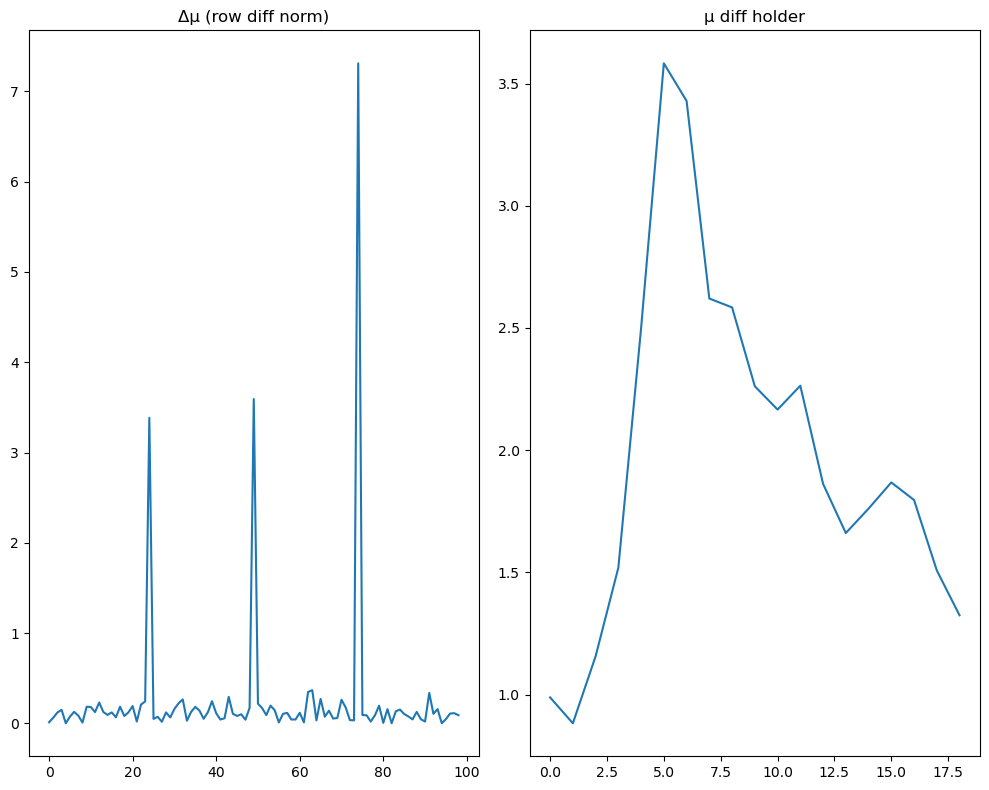

	train_loss = 560.6505126953125
	primal residual = tensor(0.09170, device='cuda:0')
	dual residual = tensor(0.09466, device='cuda:0')
		loss relative difference = tensor(0.00791, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.32422, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


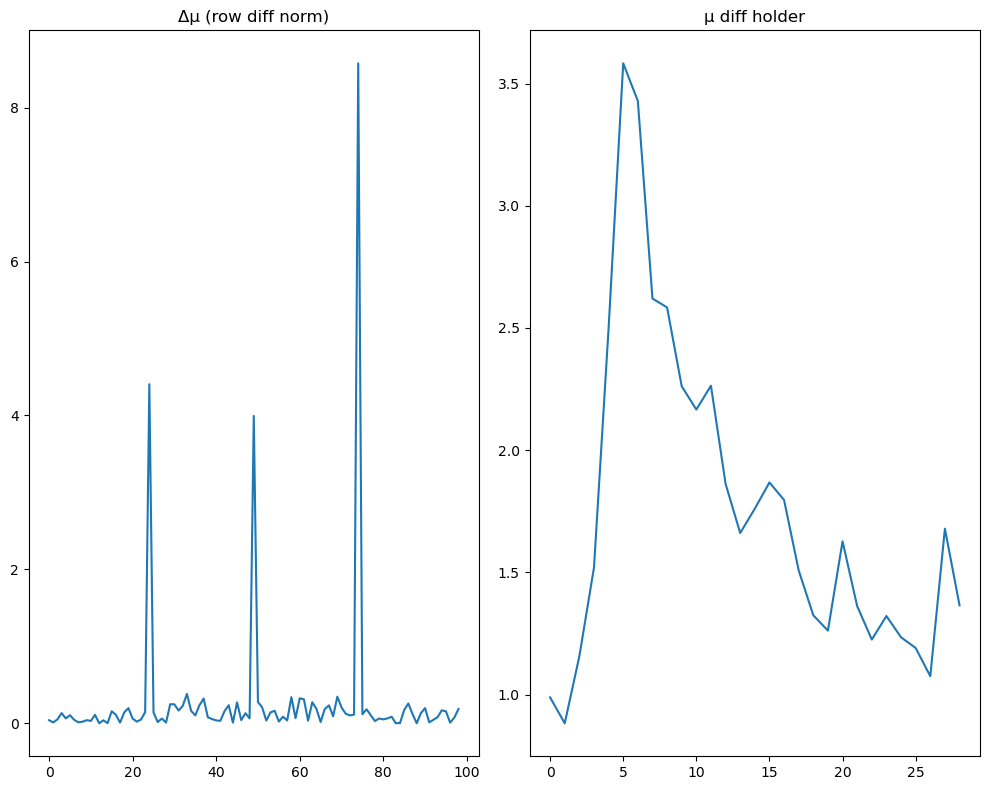

	train_loss = 534.8562622070312
	primal residual = tensor(0.09790, device='cuda:0')
	dual residual = tensor(0.09393, device='cuda:0')
		loss relative difference = tensor(0.01887, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.36492, device='cuda:0')

[INFO] Penalty 1

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


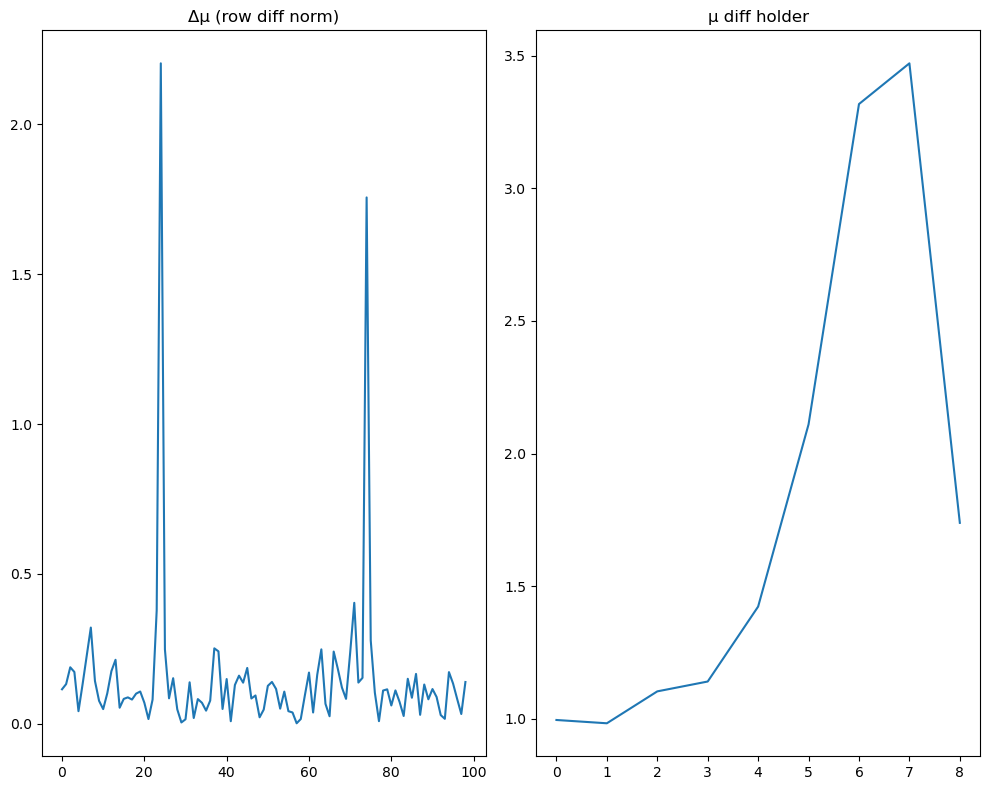

	train_loss = 674.1029052734375
	primal residual = tensor(0.12412, device='cuda:0')
	dual residual = tensor(0.15206, device='cuda:0')
		loss relative difference = tensor(0.02105, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.73851, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


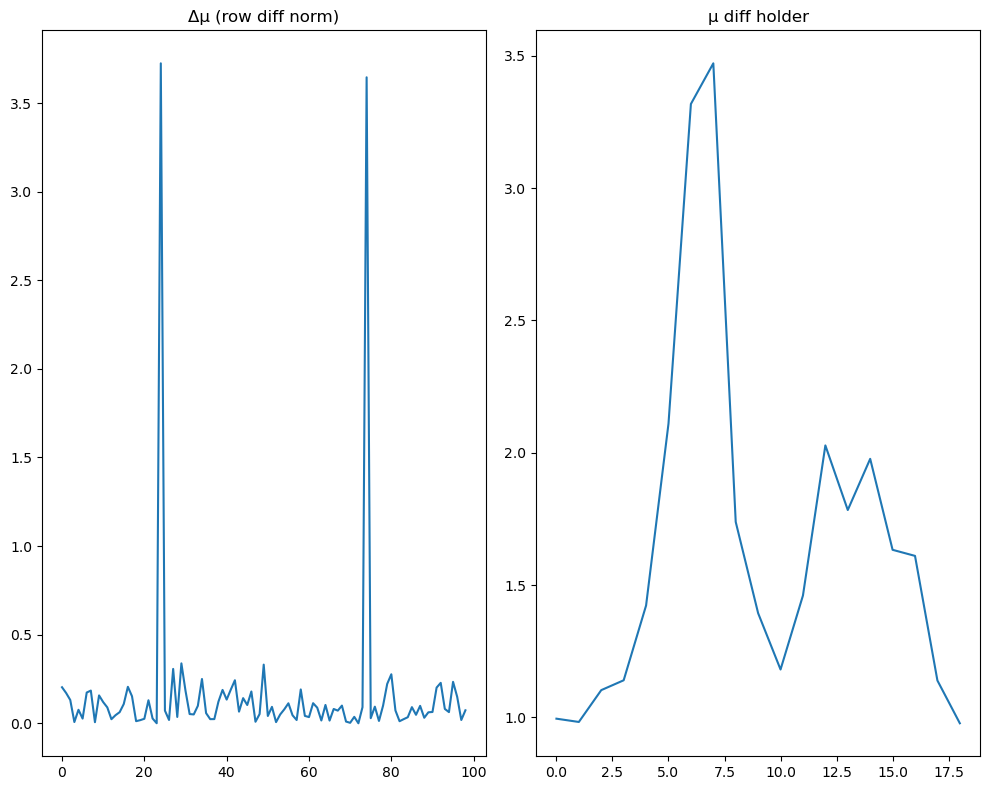

	train_loss = 605.2342529296875
	primal residual = tensor(0.08410, device='cuda:0')
	dual residual = tensor(0.10780, device='cuda:0')
		loss relative difference = tensor(0.00243, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(0.97777, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


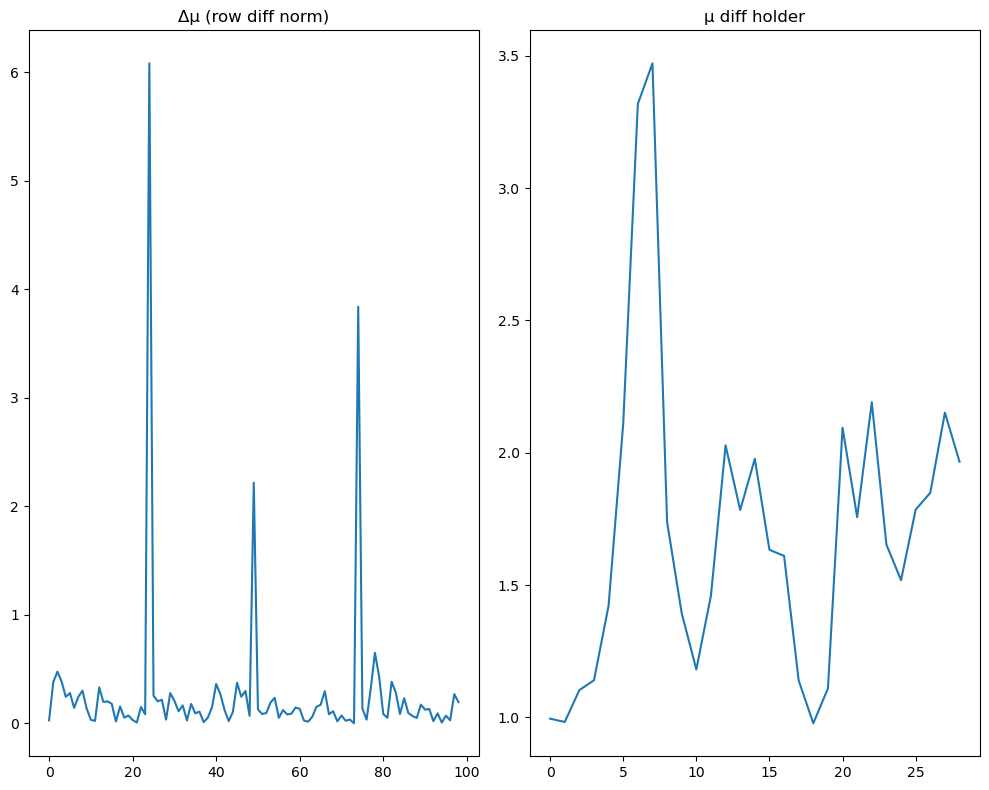

	train_loss = 604.9038696289062
	primal residual = tensor(0.13237, device='cuda:0')
	dual residual = tensor(0.12909, device='cuda:0')
		loss relative difference = tensor(0.00606, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.96616, device='cuda:0')

[INFO] Penalty 10

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


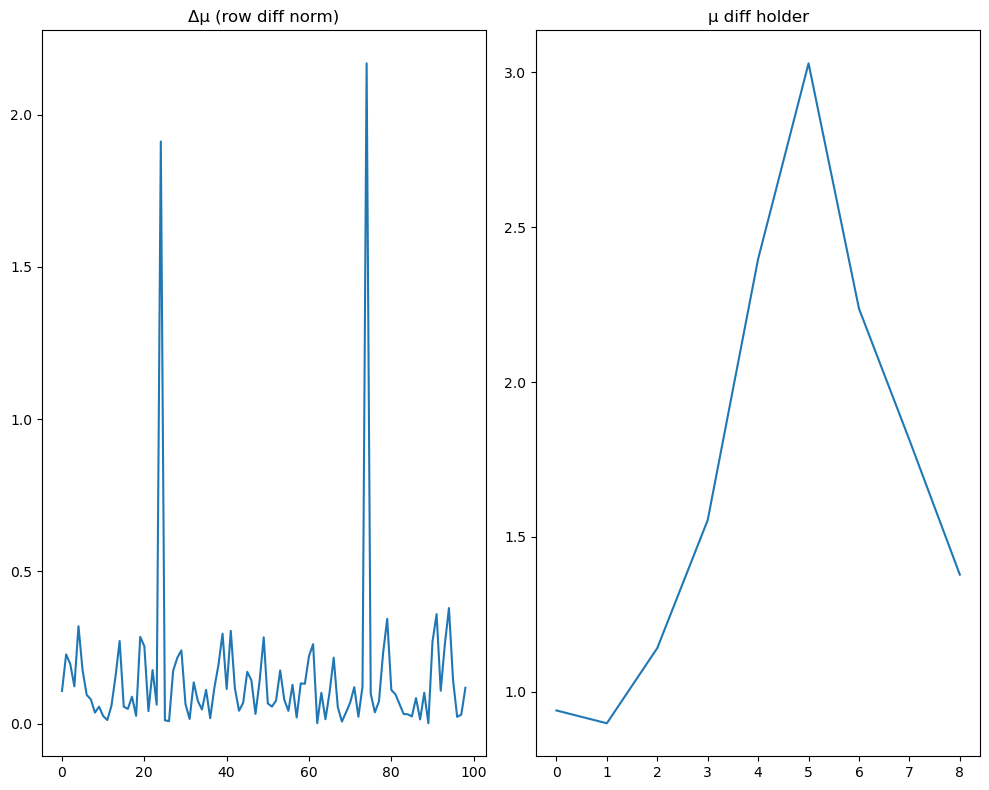

	train_loss = 650.7774658203125
	primal residual = tensor(0.61019, device='cuda:0')
	dual residual = tensor(0.35893, device='cuda:0')
		loss relative difference = tensor(0.01396, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.37799, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


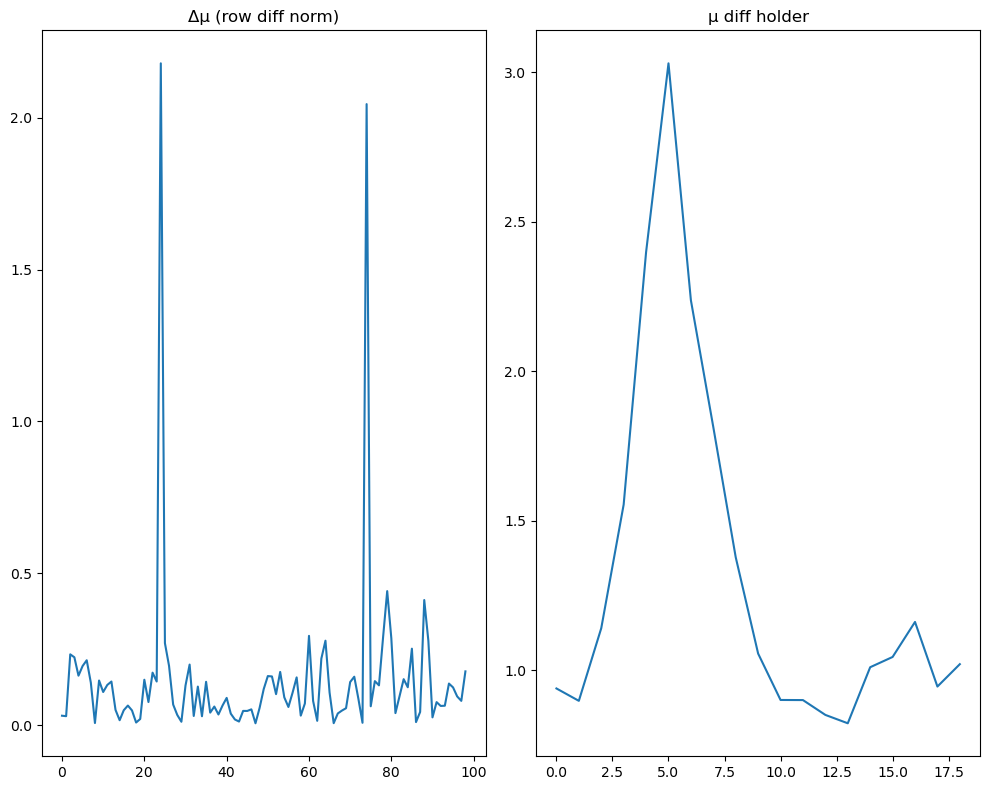

	train_loss = 608.7969360351562
	primal residual = tensor(0.10522, device='cuda:0')
	dual residual = tensor(0.03294, device='cuda:0')
		loss relative difference = tensor(0.00269, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.02058, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


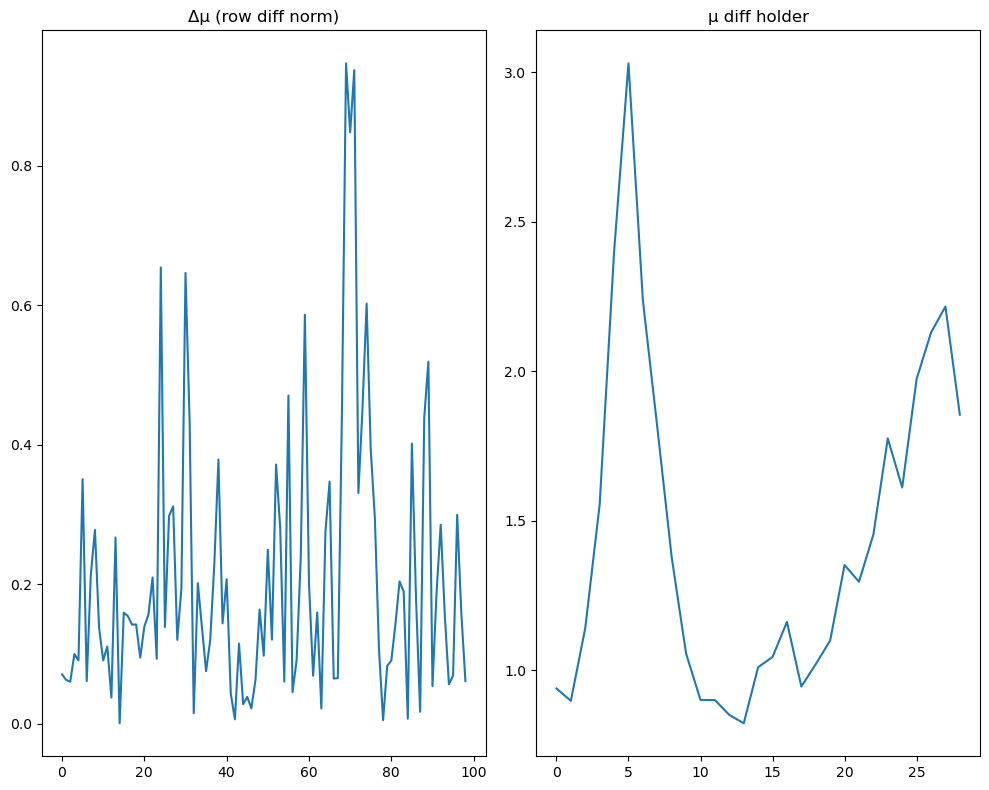

	train_loss = 671.8279418945312
	primal residual = tensor(0.20736, device='cuda:0')
	dual residual = tensor(0.09069, device='cuda:0')
		loss relative difference = tensor(0.02377, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.85472, device='cuda:0')

[INFO] Penalty 50

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


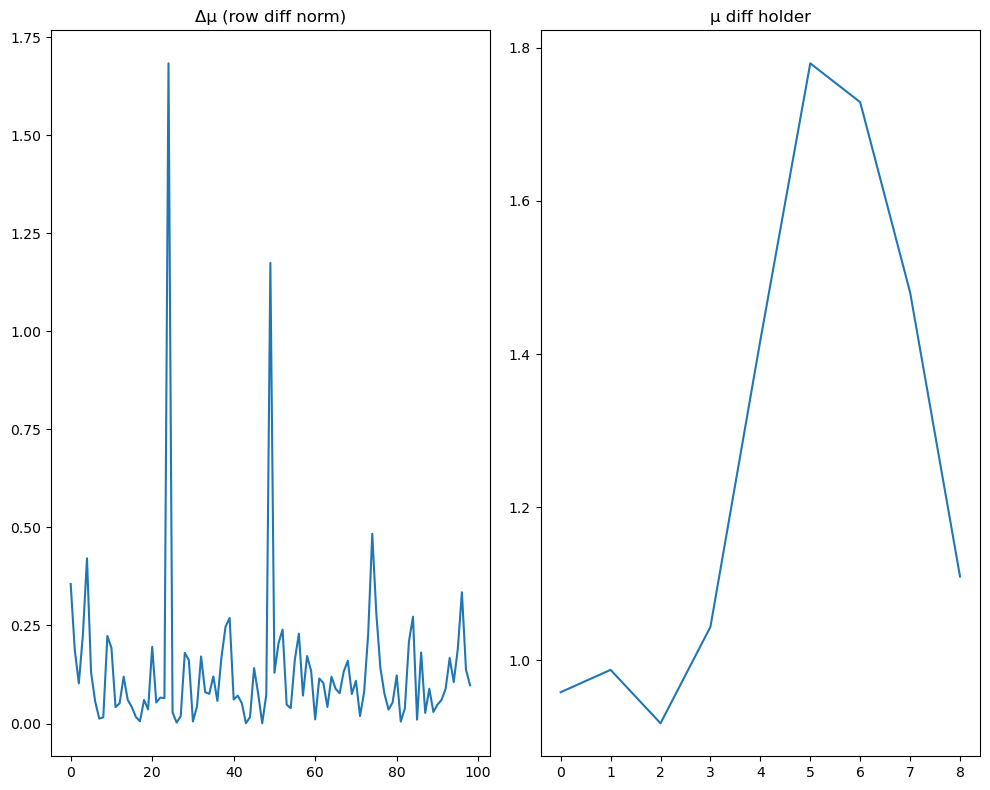

	train_loss = 683.9815673828125
	primal residual = tensor(0.65801, device='cuda:0')
	dual residual = tensor(0.00657, device='cuda:0')
		loss relative difference = tensor(0.05064, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.10926, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


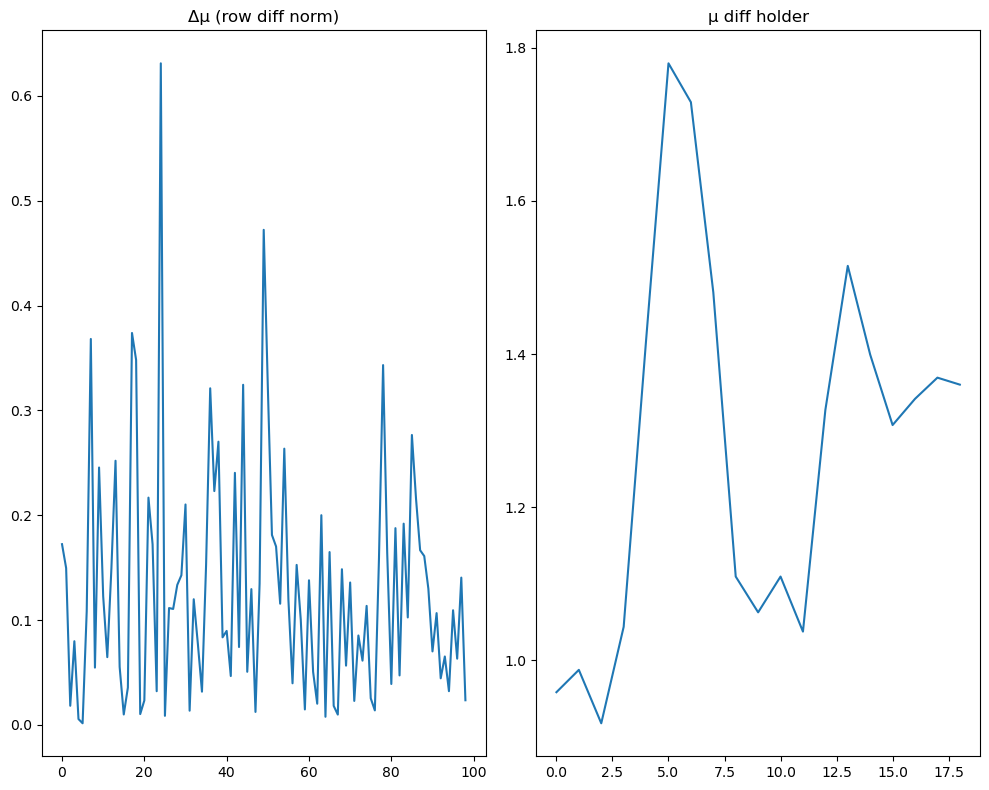

	train_loss = 662.4317016601562
	primal residual = tensor(0.25549, device='cuda:0')
	dual residual = tensor(0.00444, device='cuda:0')
		loss relative difference = tensor(0.02637, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.36002, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


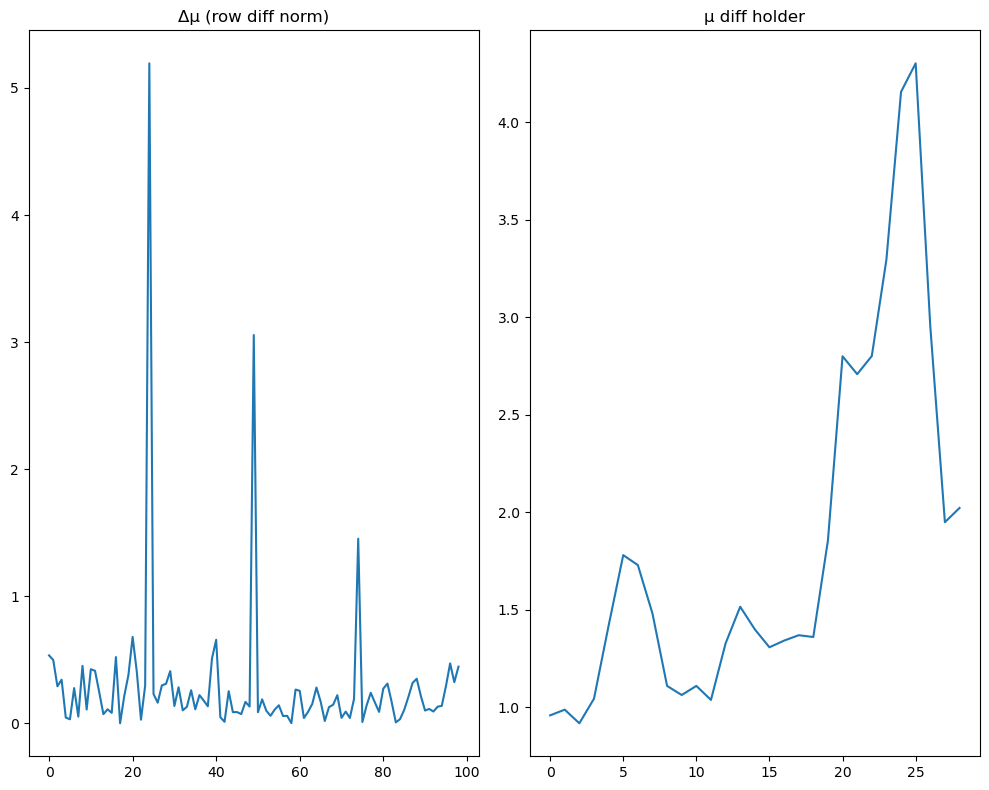

	train_loss = 735.2310791015625
	primal residual = tensor(1.88645, device='cuda:0')
	dual residual = tensor(0.09157, device='cuda:0')
		loss relative difference = tensor(0.01468, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(2.02181, device='cuda:0')

[INFO] Penalty 100

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


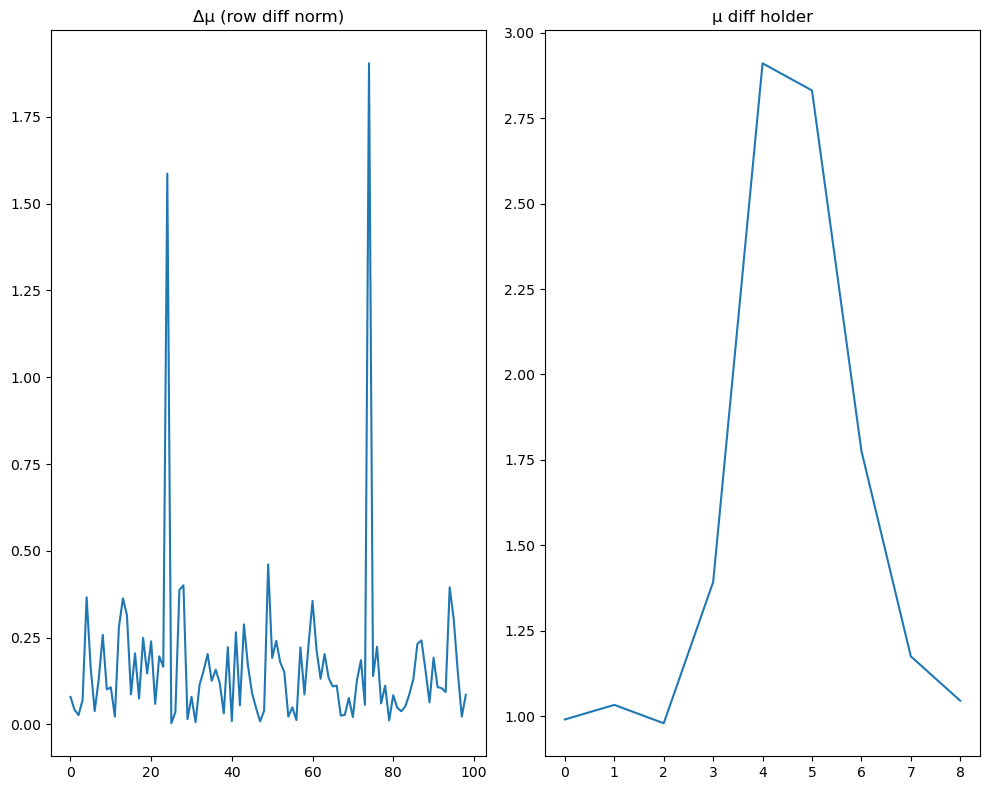

	train_loss = 657.5029296875
	primal residual = tensor(0.82933, device='cuda:0')
	dual residual = tensor(0.00720, device='cuda:0')
		loss relative difference = tensor(0.01981, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.04482, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


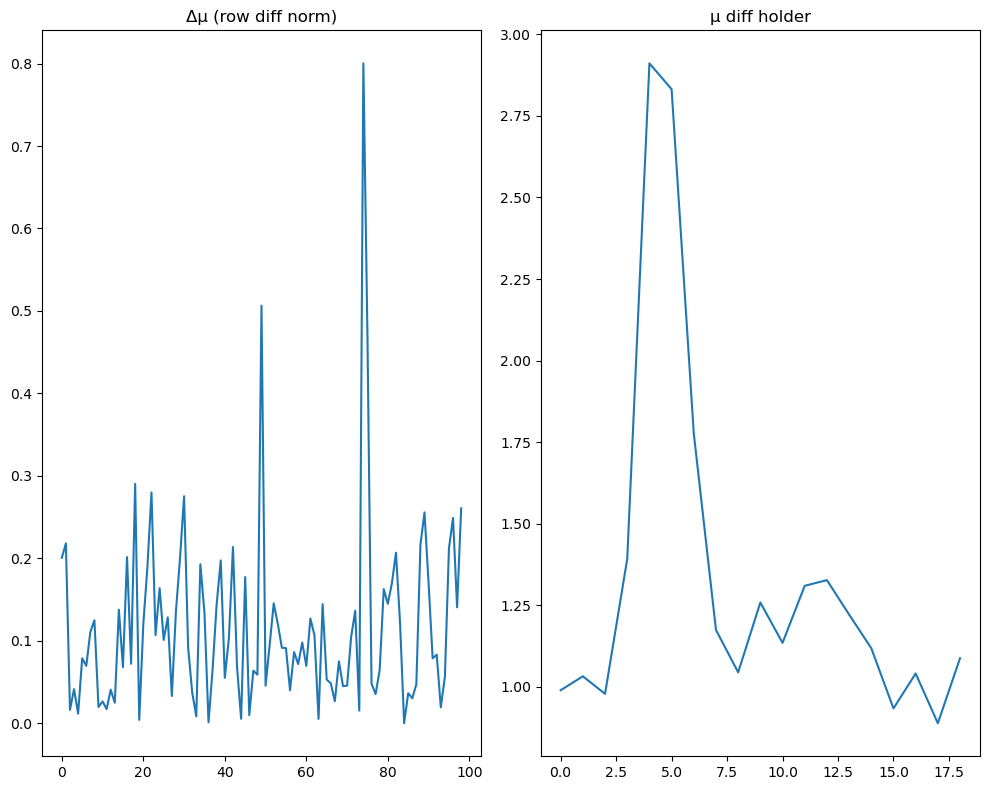

	train_loss = 651.7340087890625
	primal residual = tensor(0.23461, device='cuda:0')
	dual residual = tensor(0.00248, device='cuda:0')
		loss relative difference = tensor(0.00162, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.08826, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


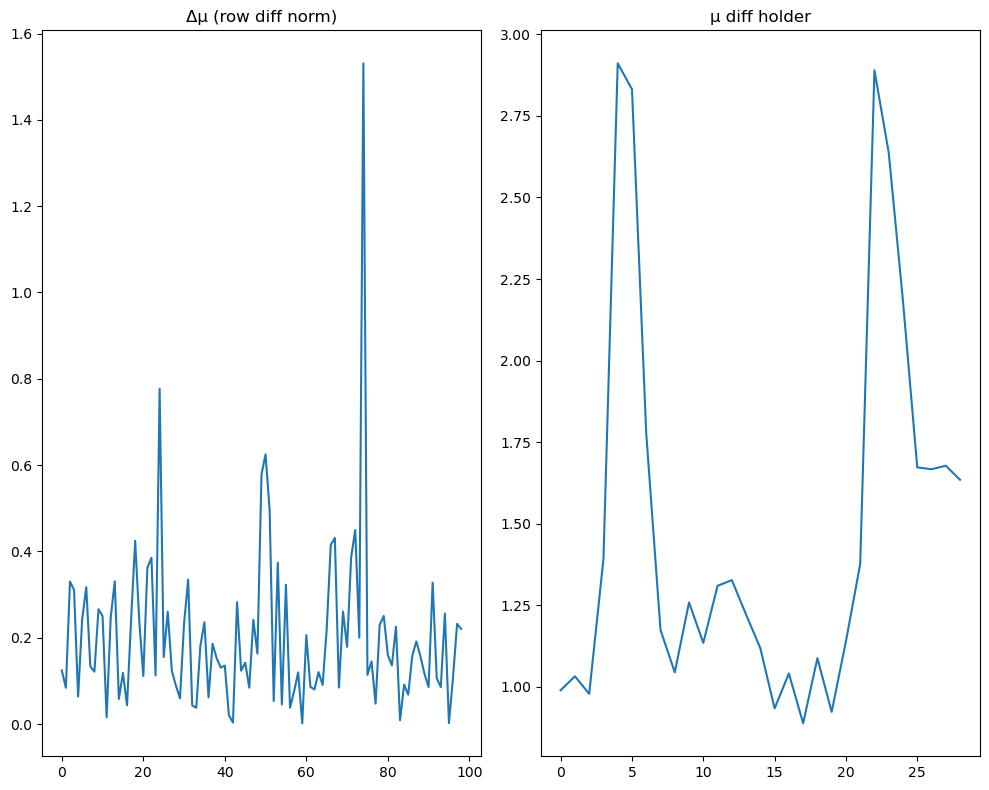

	train_loss = 720.8046875
	primal residual = tensor(0.69179, device='cuda:0')
	dual residual = tensor(0.00155, device='cuda:0')
		loss relative difference = tensor(0.00222, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(1.63485, device='cuda:0')

[INFO] Penalty 1000

[INFO] Epoch 0
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 1
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 2
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 3
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 4
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 5
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 6
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 7
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 8
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 9
torch.Size([10000, 1])
torch.Size([10000, 1])


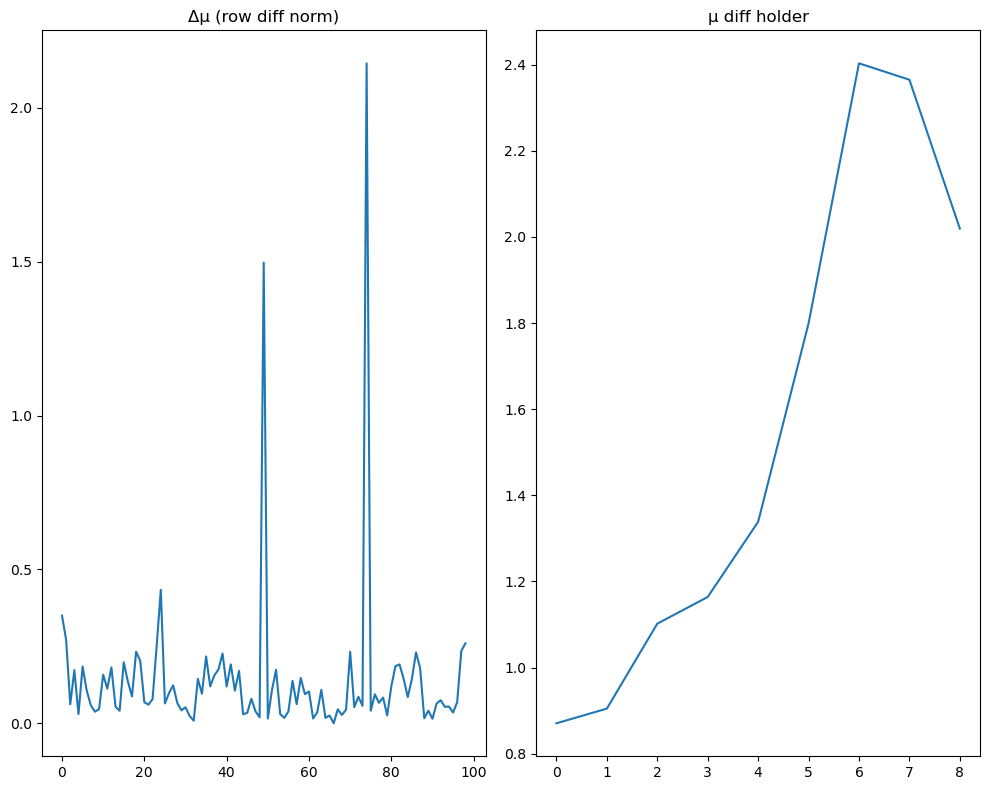

	train_loss = 649.0692138671875
	primal residual = tensor(0.88464, device='cuda:0')
	dual residual = tensor(0.03537, device='cuda:0')
		loss relative difference = tensor(0.08718, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(2.01938, device='cuda:0')

[INFO] Epoch 10
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 11
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 12
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 13
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 14
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 15
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 16
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 17
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 18
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 19
torch.Size([10000, 1])
torch.Size([10000, 1])


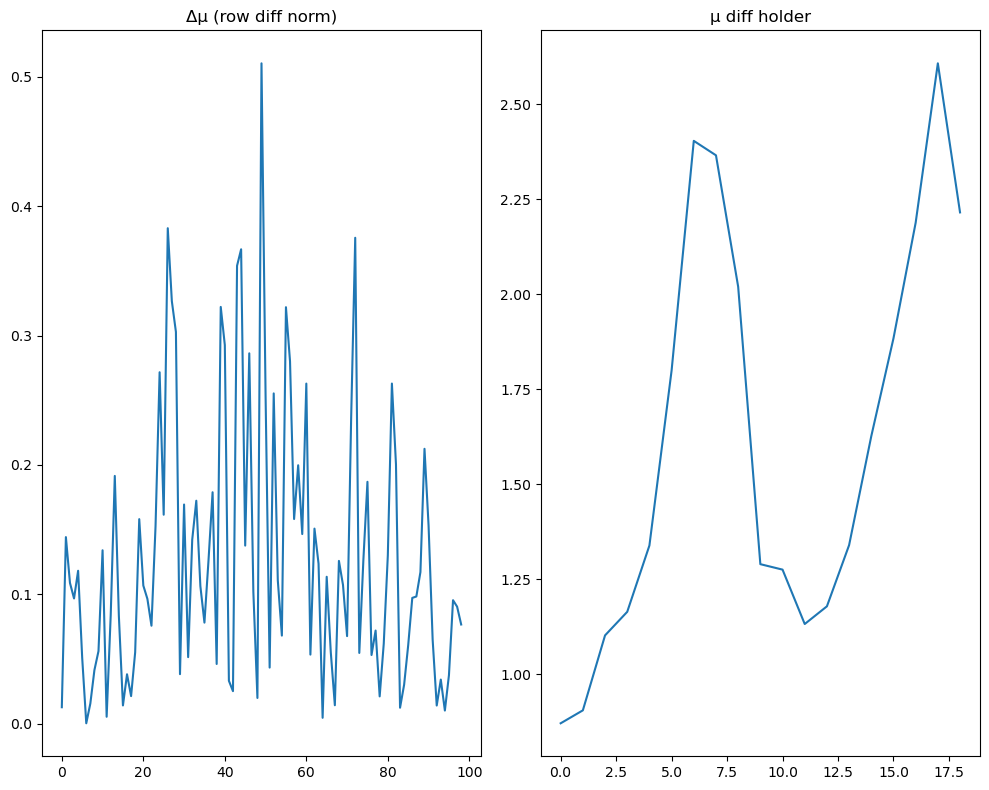

	train_loss = 680.0534057617188
	primal residual = tensor(0.20968, device='cuda:0')
	dual residual = tensor(0.02489, device='cuda:0')
		loss relative difference = tensor(0.02426, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(2.21482, device='cuda:0')

[INFO] Epoch 20
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 21
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 22
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 23
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 24
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 25
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 26
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 27
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 28
torch.Size([10000, 1])
torch.Size([10000, 1])

[INFO] Epoch 29
torch.Size([10000, 1])
torch.Size([10000, 1])


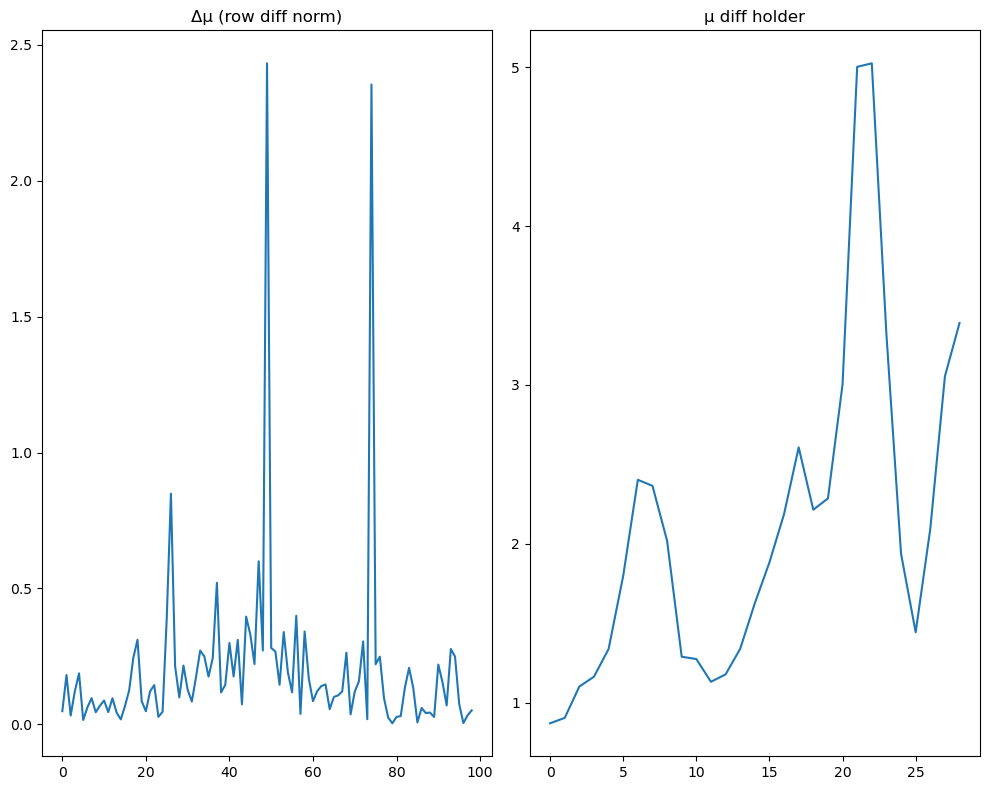

	train_loss = 690.1906127929688
	primal residual = tensor(1.01748, device='cuda:0')
	dual residual = tensor(0.01877, device='cuda:0')
		loss relative difference = tensor(0.00460, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(3.38990, device='cuda:0')
(6, 2)
[[5.40181519e+02 1.00000000e-01]
 [6.02036011e+02 1.00000000e+00]
 [6.92573669e+02 1.00000000e+01]
 [7.46065857e+02 5.00000000e+01]
 [7.33113342e+02 1.00000000e+02]
 [7.04636169e+02 1.00000000e+03]]


In [9]:
# Split the data
x_input = torch.tensor(x_all, dtype=torch.float32).reshape(args.num_time, args.num_samples, args.x_dim).to(device)
y_input = torch.tensor(y_all, dtype=torch.float32).reshape(args.num_time, args.num_samples, args.y_dim).to(device)


odd_idx = range(1, args.num_time, 2)
even_idx = range(0, args.num_time, 2)
x_input_train = x_input[odd_idx, :, :]
x_input_test  = x_input[even_idx, :, :]
y_input_train = y_input[odd_idx, :, :]
y_input_test  = y_input[even_idx, :, :]

x_input_train = x_input_train.reshape(-1, args.x_dim)   # (T/2 * N, x_dim)
x_input_test  = x_input_test.reshape(-1, args.x_dim)
y_input_train = y_input_train.reshape(-1, args.y_dim)
y_input_test  = y_input_test.reshape(-1, args.y_dim)


# res_half = learn_one_seq_penalty(args, x_input_train, y_input_train,x_input_test, y_input_test, penalty=1, half=True)
# res_half

results = []

for penalty in args.penalties: 
    a, b = learn_one_seq_penalty(
        args,
        x_input_train, y_input_train,
        x_input_test, y_input_test,
        penalty=penalty,
        half=True
    )
    results.append([a, b])

results = np.array(results)   # shape = (len(args.penalties), 2)
print(results.shape)
print(results)


In [11]:
x_all = pd.read_csv("./sim_data/x_all_3cp.csv").iloc[:, 2:].values   # (T*N, dx)
z_all = pd.read_csv("./sim_data/z_all_3cp.csv").iloc[:, 2:].values   # (T*N, dz)
y_all = pd.read_csv("./sim_data/y_all_3cp.csv").iloc[:, 2:].values   # (T*N, dy)


x_input = torch.tensor(x_all, dtype=torch.float32).to(device)
z_input = torch.tensor(z_all, dtype=torch.float32).to(device)
y_input = torch.tensor(y_all, dtype=torch.float32).to(device)


[INFO] Penalty 0.1

[INFO] Epoch 0
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 1
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 2
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 3
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 4
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 5
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 6
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 7
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 8
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 9
torch.Size([20000, 1])
torch.Size([20000, 1])


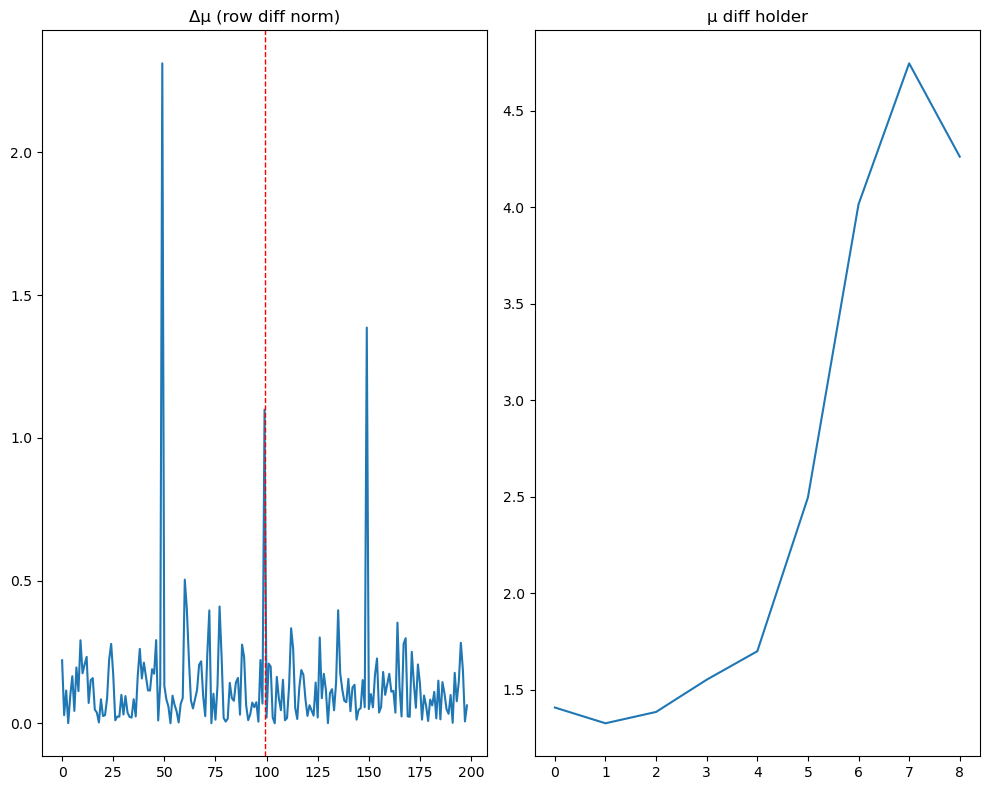

	train_loss = 1365.193115234375
	primal residual = tensor(0.14357, device='cuda:0')
	dual residual = tensor(0.28185, device='cuda:0')
		loss relative difference = tensor(0.08108, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(4.26133, device='cuda:0')

[INFO] Epoch 10
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 11
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 12
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 13
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 14
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 15
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 16
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 17
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 18
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 19
torch.Size([20000, 1])
torch.Size([20000, 1])


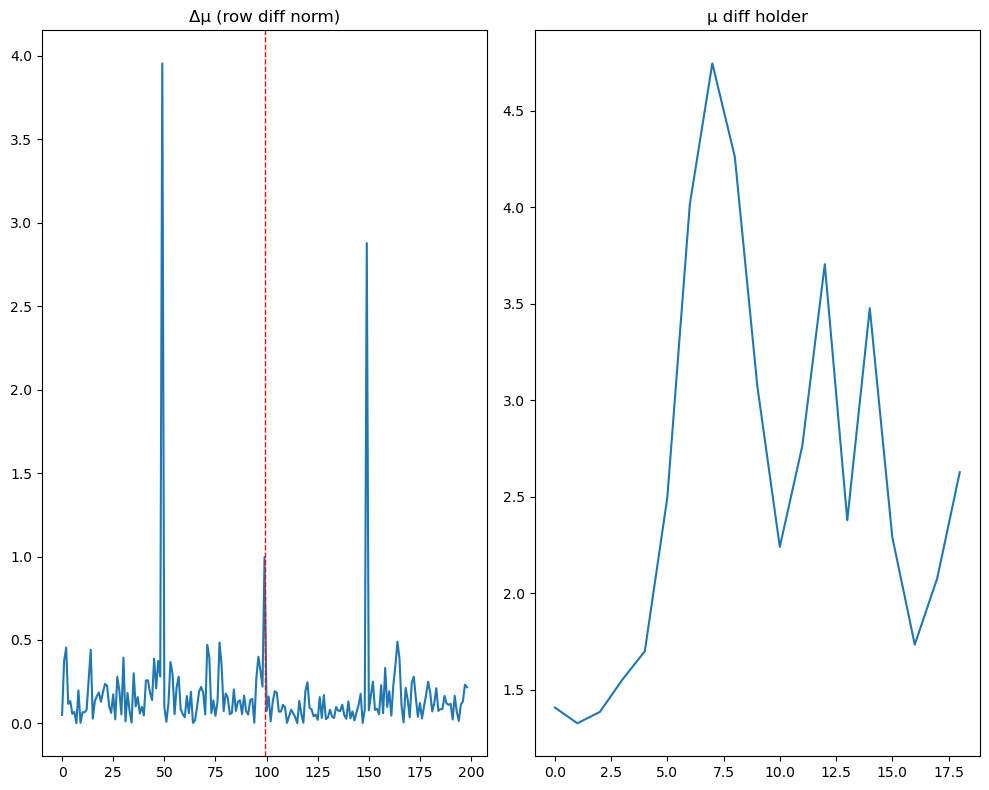

	train_loss = 1226.861083984375
	primal residual = tensor(0.41963, device='cuda:0')
	dual residual = tensor(0.37857, device='cuda:0')
		loss relative difference = tensor(0.01539, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(2.62742, device='cuda:0')

[INFO] Epoch 20
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 21
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 22
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 23
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 24
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 25
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 26
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 27
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 28
torch.Size([20000, 1])
torch.Size([20000, 1])

[INFO] Epoch 29
torch.Size([20000, 1])
torch.Size([20000, 1])


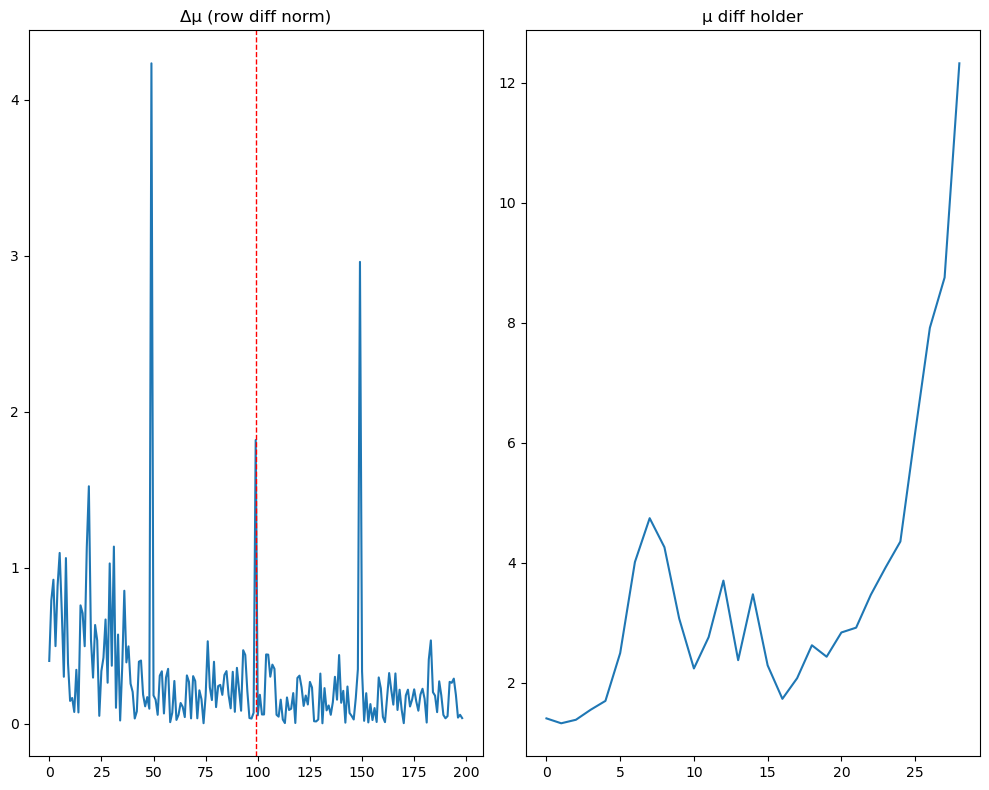

	train_loss = 1240.208251953125
	primal residual = tensor(5.94300, device='cuda:0')
	dual residual = tensor(3.93201, device='cuda:0')
		loss relative difference = tensor(0.01499, device='cuda:0', grad_fn=<AbsBackward0>)
		mu relative difference = tensor(12.32471, device='cuda:0')


(array(1240.2083, dtype=float32),
 array([[-6.27300835e+00],
        [-5.86967516e+00],
        [-5.07712889e+00],
        [-4.15311623e+00],
        [-3.65486264e+00],
        [-2.77059436e+00],
        [-1.67477751e+00],
        [-9.50884044e-01],
        [-6.48902833e-01],
        [ 4.13956523e-01],
        [ 8.02024722e-01],
        [ 9.49202657e-01],
        [ 1.11513710e+00],
        [ 1.19147348e+00],
        [ 8.44921172e-01],
        [ 7.71638215e-01],
        [ 1.20483739e-02],
        [-6.97678626e-01],
        [-1.19532013e+00],
        [-2.32564998e+00],
        [-3.84872246e+00],
        [-4.38990164e+00],
        [-4.68642998e+00],
        [-5.32026291e+00],
        [-5.85541010e+00],
        [-5.90689278e+00],
        [-6.24524021e+00],
        [-5.82081318e+00],
        [-5.15168285e+00],
        [-4.88790083e+00],
        [-3.85947084e+00],
        [-3.48678899e+00],
        [-2.35039306e+00],
        [-2.24729109e+00],
        [-1.67478192e+00],
        [-1.69641924e

In [12]:
# Test passed.
best_idx = np.argmin(results[:, 0])

res_full = learn_one_seq_penalty(
    args,
    x_input, y_input,
    x_input, y_input,
    penalty=args.penalties[best_idx],
    half=False
)
res_full